# Table of Contents

    1. Introduction

    2. Dataset Preparation
    
    3. Exploratory Data Analysis

    4.  KNN

        4.1 Hyperparameter Tuning on  KNN Algorithm
        4.2 Building RecSys based on KNN
        4.3 Evaulation of KNN Model 
    

    5. SVD

            5.1. Building RecSys based on SVD
            5.2. Evaulation of SVD Model

    6.Conclusion
          

# 1. Introduction

Recommender systems have become increasingly important in recent years due to the abundance of data and the need for personalized recommendations. In this assignment, two recommender systems based on K-Nearest Neighbors (KNN) and Singular Value Decomposition (SVD) techniques are built by using the Netflix Prize dataset. 

While KNN Model will recommend movies based on the **user-user similarity**, SVD Model will recommend movies based on **movie-movie similarity**. The KNN technique finds the k most similar users to a given user and uses their ratings to make movie recommendations, while the SVD model factorizes the user-movie matrix into lower-rank matrices to make recommendations based on similar movies to the user's recent-highest-rated movie.

This assignment is  conducted by Dilay Durukan, a student of the Master's programme Digital Driven Business, as part of the course System Development for Marketing’. This assignment will provide valuable insights into the application of collaborative filtering techniques in building RecSys.

The following main Business question has been formulated: 


 **How can we build  movie recommendations system for providing personalized movie recommendations based on their past ratings?**


To answer this main Business questions the following five sub-questions have been defined:

1. What is the distribution of movies, users and ratings on our platform?


2. What kind of techniques can be used for recommendation systems for movie recommendations?

3. Which algorithms can be used for identifying similar patterns and recommending movies based on these patterns?

4. How can we measure the accuracy of our KNN and SVD models in predicting user ratings for movies?

# 2. Dataset Preparation

In this section dataset is filtered and rearranged for further purposes

In [1]:
# Importing Necessary libraries 
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.cm as cm


from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split

import scipy.stats as stats
import IPython
import glob, os
from wordcloud import WordCloud
from scipy.sparse import csr_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import NearestNeighbors
from numpy.linalg import svd
from IPython.display import display


from contextlib import redirect_stdout
from io import StringIO

pd.set_option('display.max_columns', None)

# Turns off chained assignment warning of pandas
pd.set_option('mode.chained_assignment', None)

In [2]:
# Opening and combining all the combined data files
# In order to run the algorithm faster and skip this part, data saved as data.csv 

''''
if not os.path.isfile('data.csv'):
    data = open('data.csv', mode='w')

files = ['combined_data_1.txt'           # Because of the RAM memory issue, only  combined_data_1 is read.
#          ,'combined_data_2.txt',
#          'combined_data_3.txt',  
#          'combined_data_4.txt'
        ]


# Combine all data files into a csv file
for file in files:
  print("Opening file: {}".format(file))
  with open(file) as f:
    for line in f:
        line = line.strip()
        if line.endswith(':'):
            movie_id = line.replace(':', '')
        else:
            data.write(movie_id + ',' + line)
            data.write('\n')
data.close()

'''


'\'\nif not os.path.isfile(\'data.csv\'):\n    data = open(\'data.csv\', mode=\'w\')\n\nfiles = [\'combined_data_1.txt\'           # Because of the RAM memory issue, only  combined_data_1 is read.\n#          ,\'combined_data_2.txt\',\n#          \'combined_data_3.txt\',  \n#          \'combined_data_4.txt\'\n        ]\n\n\n# Combine all data files into a csv file\nfor file in files:\n  print("Opening file: {}".format(file))\n  with open(file) as f:\n    for line in f:\n        line = line.strip()\n        if line.endswith(\':\'):\n            movie_id = line.replace(\':\', \'\')\n        else:\n            data.write(movie_id + \',\' + line)\n            data.write(\'\n\')\ndata.close()\n\n'

In [3]:
# Reading the data into a pd dataframe
df = pd.read_csv('data.csv', names=['movie_id', 'user_id','rating','date'])
print(df.nunique())
print('Shape of Movie-User Data :\t{}'.format(df.shape))
df.head()

movie_id      4499
user_id     470758
rating           5
date          2182
dtype: int64
Shape of Movie-User Data :	(24053764, 4)


,movie_id,user_id,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


Dataset contains 4499 different movies, 470758 users and 5 different rating levels ranging from 1 to 5.

In [4]:
# Checking the missing values
df.isnull().sum()

movie_id    0
user_id     0
rating      0
date        0
dtype: int64

In [5]:
# Loading data for  movie titles
movie_titles = pd.read_csv('movie_titles.txt', 
                           encoding = 'ISO-8859-1', 
                           header = None, 
                           names = ['movie_id', 'YearOfRelease', 'movie_title'], on_bad_lines='skip')

print('Shape of Movie-Titles:\t{}'.format(movie_titles.shape))
movie_titles.head()

Shape of Movie-Titles:	(17770, 3)


,movie_id,YearOfRelease,movie_title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [6]:
print ('There are ', movie_titles.isnull().sum().iloc[1] , ' empty cells in YearOfRelease')
movie_titles['YearOfRelease'] = movie_titles['YearOfRelease'].fillna(0)
movie_titles['YearOfRelease'] = movie_titles['YearOfRelease'].astype(int)


There are  7  empty cells in YearOfRelease


In [7]:
#Merging two dataset 
df=pd.merge(df,movie_titles,on='movie_id')
df.head()

,movie_id,user_id,rating,date,YearOfRelease,movie_title
0,1,1488844,3,2005-09-06,2003,Dinosaur Planet
1,1,822109,5,2005-05-13,2003,Dinosaur Planet
2,1,885013,4,2005-10-19,2003,Dinosaur Planet
3,1,30878,4,2005-12-26,2003,Dinosaur Planet
4,1,823519,3,2004-05-03,2003,Dinosaur Planet


In [8]:
"""
#Filtering the dataset based on some condition on popularity
##Filtered data was still too large to run the algorithm, so this filtering technique is not used

min_movie = 100   # movie has to have been rated over 100 times
min_user = 100   # user has to have rated at least 100 times

users = df.groupby('user_id')['rating'].count()
users = users.loc[users > min_user].index.values
movies = df.groupby('movie_id')['rating'].count()
movies = movies.loc[movies > min_movie].index.values
df_filtered = df.loc[df.user_id.isin(users) & df.movie_id.isin(movies)]
"""

"\n#Filtering the dataset based on some condition on popularity\n##Filtered data was still too large to run the algorithm, so this filtering technique is not used\n\nmin_movie = 100   # movie has to have been rated over 100 times\nmin_user = 100   # user has to have rated at least 100 times\n\nusers = df.groupby('user_id')['rating'].count()\nusers = users.loc[users > min_user].index.values\nmovies = df.groupby('movie_id')['rating'].count()\nmovies = movies.loc[movies > min_movie].index.values\ndf_filtered = df.loc[df.user_id.isin(users) & df.movie_id.isin(movies)]\n"

In [9]:
#In order to run the code faster, data is filtered  to 1000 movies

df_filtered = df[df['movie_id'] <= 1000]

In [10]:
print('Unfiltered: ', df.shape[0])
print('Filtered: ', df_filtered.shape[0])
print('Kept {}% of data'.format(round(df_filtered.shape[0]/df.shape[0], 2)*100))

Unfiltered:  24053764
Filtered:  5010199
Kept 21.0% of data


In [11]:
# sorting df_filtered by  user_id and movie_id in ascending order
df_filtered = df_filtered.sort_values(['user_id','movie_id',])

# 3. Exploratory Data Analysis

In this step, we go through EDA to understand the data.

In [12]:
#Defining a list of colors that can be used in creating visualizations
colors = sns.color_palette("Paired")

(-0.5, 799.5, 399.5, -0.5)

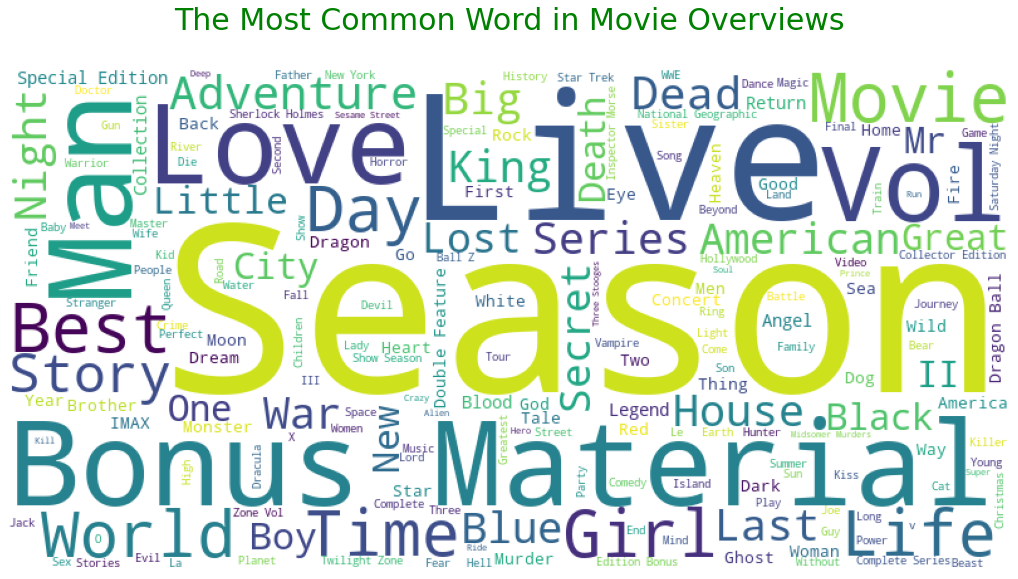

In [13]:
# The Most Common Word in Movie Titles Overwiews
plt.figure(figsize=(18,18))
plt.title('The Most Common Word in Movie Overviews\n', fontsize=30, weight=500, color='green')
wc = WordCloud(width=800, height=400, background_color='white').generate(' '.join(movie_titles['movie_title']))

plt.imshow(wc)
plt.axis('off')

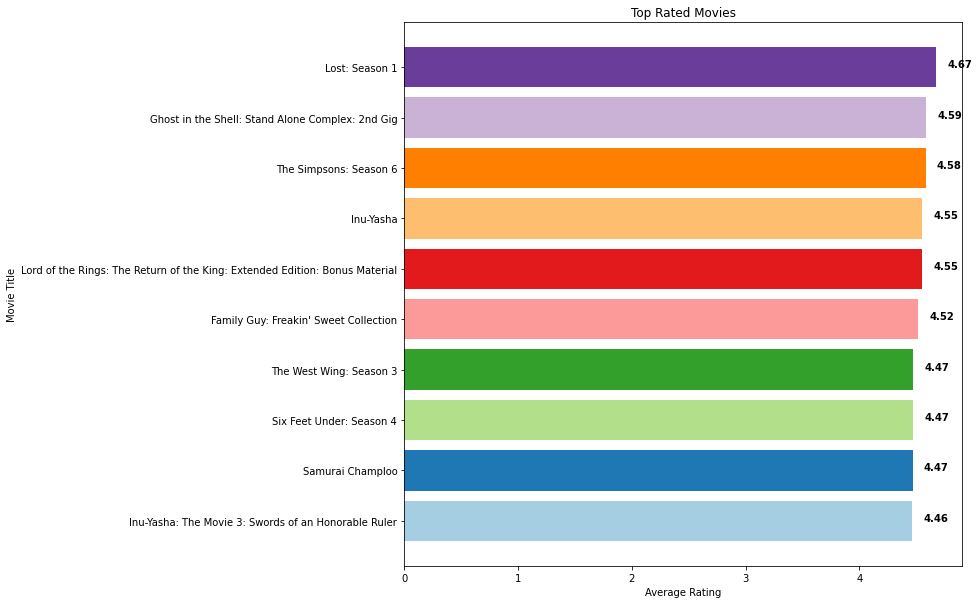

In [14]:
# Top Rated Movies Plot
plt.figure(figsize=(10,10))
top_rated = df.groupby('movie_title')['rating'].mean().nlargest(10)
plt.barh(top_rated.index[::-1], top_rated[::-1], color=colors)
plt.title('Top Rated Movies')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
for i, v in enumerate(top_rated[::-1]):
    plt.text(v + 0.1, i, f"{v:.2f}", color='black', fontweight='bold')
plt.show()

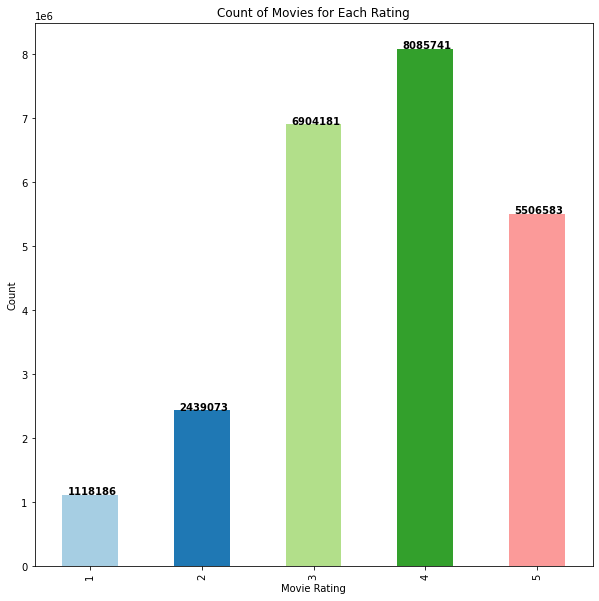

In [15]:
# Count of Movies for Each Rating Plot
plt.figure(figsize=(10,10))


counts = df['rating'].value_counts(sort=False)
counts = counts.sort_index()
ax = counts.plot(kind='bar', color=colors)
ax.set_xlabel('Movie Rating')
ax.set_ylabel('Count')
ax.set_title('Count of Movies for Each Rating')

# add the count of movies on top of each bar
for x, y in enumerate(counts):
    ax.text(x-0.2, y+145, str(y), color='black', fontweight='bold')

# show the plot
plt.show()

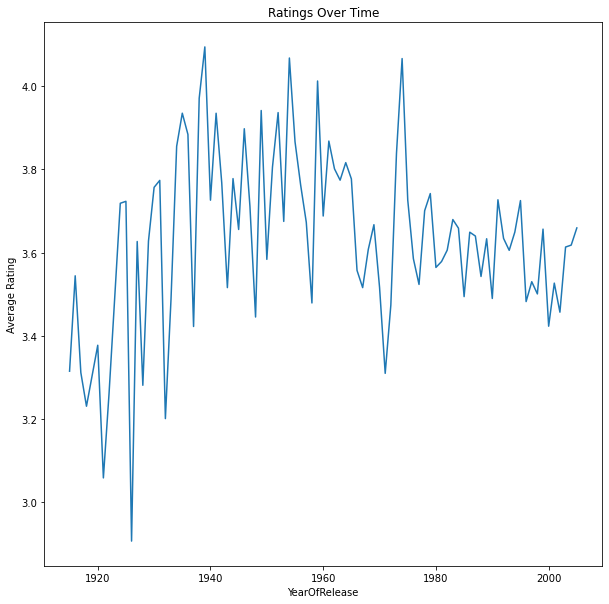

In [16]:
# Ratings over time Plot
plt.figure(figsize=(10,10))

min_year = df[df['YearOfRelease'] != 0]['YearOfRelease'].min()
df6 = df[df['YearOfRelease'] >= min_year]

plt.plot(df6.groupby('YearOfRelease')['rating'].mean(), color=colors[1])
plt.title('Ratings Over Time')
plt.xlabel('YearOfRelease')
plt.ylabel('Average Rating')
plt.show()

# 4. KNN

The exponential growth of digital media has resulted in an overwhelming number of choices when it comes to selecting a movie to watch on streaming platforms such as Netflix. To address this issue, a recommendation system is developed that utilizes the K-Nearest Neighbors (KNN) algorithm to provide personalized recommendations.

The KNN model built in this assignment is based on the **user-user similarity**.

The Knn recommendation system takes user ID as an input and identifies 10 similar users using the KNN algorithm. It then recommends the movie with the highest average rating among the 10 similar users.

The system is built on the Netflix Prize dataset, which includes movie IDs, customer IDs, and movie ratings. By leveraging this data, it is able to provide users with recommendations that are tailored to their preferences and viewing history.

In [17]:
# Creating User-Movie Matrix
movie_user_matrix=df_filtered.pivot(index='user_id', columns= 'movie_id',values='rating').fillna(0)

In [18]:
# Split the dataset into train and test sets

movie_user_train, movie_user_test = train_test_split(movie_user_matrix, test_size=0.2, shuffle=False)

train_data=  df_filtered[df_filtered['user_id'].isin(movie_user_matrix.index.tolist())]
test_data= df_filtered[df_filtered['user_id'].isin(movie_user_matrix.index.tolist())]

In [19]:
# Preprocess the data into a sparse matrix format
csrtrain = csr_matrix(movie_user_train.values)

##  4.1 Hyperparameter Tuning on  KNN Algorithm

The goal of hyperparameter tuning is to find the combination of hyperparameters that produces the best performance on the given dataset. The hyperparameters are values that are set before training the model and cannot be learned during training.  In this assignment hyperparameter tuning is done by searching through a range of possible hyperparameters and evaluating the performance of the model using each combination. The evaluation metric used to measure performance is selected as mean of the distances of nearest neighbors aka similar users. If this metric is low it means that the distances are small and neighbors are similar. If this metric is high then distances to neighbors are higher and users are less similar. The hyperparameters that result in the best performance on the evaluation metric(minimum distance) are selected as the optimal hyperparameters for the model.

In [20]:
#Creating an empty dataframe to store the results of hyperparameter tuning for KNN algorithm
knn_tuning_results = pd.DataFrame(columns=['n_neighbors', 'algorithm', 'metric','mean_distances'])

#Defining the range of hyperparameters to be tuned
#Having 2*2*2 combinations for hyperparameters tooks more than 9 hours to run. To run the code faster i have commented out the rest of the tuning algorithm.

n_neighbors= [10, 20, 30]
algorithm= [ 'brute', 'auto']
metric=['cosine', 'euclidean']
'''

#Loop over the combinations of hyperparameters to perform the KNN algorithm with each combination
for i in n_neighbors:
    for j in  algorithm:
        for k in  metric:
            # Create a KNN object with the current hyperparameter combination
            knn = NearestNeighbors(n_neighbors=i,
                           algorithm=j,
                           metric=k)
            # Fit the KNN model with the training data
            knn.fit( csrtrain)
            # Calculate the distances and indices of similar users
            distances, indices = knn.kneighbors(csrtrain, n_neighbors=i)
            # Print the mean of distances to similar users for the current hyperparameter combination
            print('For n=' , i, '  algorithm=', j, '  metric=' , k , '  Mean of distances to similar users= ' , distances.mean())

            # Append the hyperparameter combination and mean distance to the knn_tuning_results dataframe
            knn_tuning_result = {'n_neighbors': i, 'algorithm': j,'metric': k, 'mean_distances': distances.mean()}
            knn_tuning_results = knn_tuning_results.append(knn_tuning_result, ignore_index=True)
'''

"\n\n#Loop over the combinations of hyperparameters to perform the KNN algorithm with each combination\nfor i in n_neighbors:\n    for j in  algorithm:\n        for k in  metric:\n            # Create a KNN object with the current hyperparameter combination\n            knn = NearestNeighbors(n_neighbors=i,\n                           algorithm=j,\n                           metric=k)\n            # Fit the KNN model with the training data\n            knn.fit( csrtrain)\n            # Calculate the distances and indices of similar users\n            distances, indices = knn.kneighbors(csrtrain, n_neighbors=i)\n            # Print the mean of distances to similar users for the current hyperparameter combination\n            print('For n=' , i, '  algorithm=', j, '  metric=' , k , '  Mean of distances to similar users= ' , distances.mean())\n\n            # Append the hyperparameter combination and mean distance to the knn_tuning_results dataframe\n            knn_tuning_result = {'n_ne

In the above, we can see the distances(errors) for each combination of hyperparameters for the KNN model. In the following code, the optimal hyperparameters are selected according to minimum of the distances.

In [21]:
if not knn_tuning_results.empty:

    # Finding the index of the row with the minimum mean distance
    index_min_value = knn_tuning_results['mean_distances'].idxmin()

    #Getting the optimal hyperparameters from the row with the minimum mean distance
    best_n_neighbors = knn_tuning_results.iloc[index_min_value, 0]
    best_algorithm = knn_tuning_results.iloc[index_min_value,1]
    best_metric = knn_tuning_results.iloc[index_min_value, 2]

    
else:
    #To run the code faster i have commented out the rest of the tuning algorithm in previous step. So, if the knn_tuning_results is empty, the optimal hyperparameters are set to the default values.
    best_n_neighbors =10
    best_algorithm = 'brute'
    best_metric = 'cosine'

#Printing the optimal hyperparameters
print('Optimal hyperparameters for the KNN model are n=' , best_n_neighbors, '  algorithm=', best_algorithm, '  metric=' , best_metric )

Optimal hyperparameters for the KNN model are n= 10   algorithm= brute   metric= cosine



After performing hyperparameter tuning on a KNN algorithm, the optimal hyperparameters are determined based on their ability to minimize the error of the model. Since the optimal hyperparameters are determined now, they can be used to train the KNN model with the goal of minimizing the error.

##  4.2 Building RecSys based on KNN

In [22]:
# Create a new NearestNeighbors object with the best hyperparameters found during tuning
knn = NearestNeighbors(n_neighbors=best_n_neighbors,
                           algorithm=best_algorithm,
                           metric=best_metric)

# Fitting the KNN model on the training data
knn.fit(csrtrain)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

#### - Creating a function that finds similar users to a given user

This function takes an input_user_index and neighbor_count as inputs. It calculates the k nearest neighbors of the input user based on their interaction history with movies using the KNN model trained earlier. Then, it prints the most similar users to the input user based on the calculated distances. Finally, it creates a list of similar users based on their indices in the training data and returns it.

In [23]:
def get_similar_users(input_user_index, neighbor_count=best_n_neighbors+1):
    
    # Finding the k nearest neighbors of the input user 
    distances, indices = knn.kneighbors(movie_user_matrix.iloc[input_user_index,:].values.reshape(1,-1), n_neighbors=neighbor_count)
  
    # Creating a list of similar users based on their indices in the training data    
    similaruser=[]
    

    # Printing the most similar users to the input user based on the calculated distances


    for i in range(0,len(distances.flatten())):
        if i==0:            #Most similar user to input user is itself with zero distance. So not printing the input user 
            print('Similar Users for User',movie_user_train.index[indices.flatten()[i]],' \n')
        else:
            print( 'Most Similar User',i,': User_Id ' +  str(movie_user_matrix.index[indices.flatten()[i]]),' with distance of ',str(distances.flatten()[i]) )

            # Appending the similar users to the list               
            similaruser.append(movie_user_matrix.index[indices.flatten()[i]])
    
    return similaruser

    # indices are the index of the similar users in the movie_user_train dataframe
    # movie_user_train.index[indices.flatten()[1]] are the user_ids of the similar users
    

#### - Creating a function for finding the movie with the highest average rating

This function takes a pandas DataFrame object 'MoviesfromSimilarUsers' as input, which contains a list of movies and their average rating by similar users. 
The code first converts the 'movie_id', 'avg_rating_by_similar_users', and 'movie_title' columns of the DataFrame into lists using the 'tolist()' method.
Then, it initializes variables to keep track of the maximum rating and the recommended movie. 
The code loops through the lists to find the movie with the highest rating. For each movie, the code checks whether its rating is greater than the current maximum rating (maxrating). If so, the movie title is stored in the movie variable and its rating is stored in the maxrating variable. 
Finally, the function returns the recommended movie with the highest rating.

In [24]:
def get_Movie_with_Highhest_Rating_from_Similar_Users(MoviesfromSimilarUsers):

    # Converting movie_id, movie_title and avg_rating_by_similar_users columns to lists

    movieidlist=MoviesfromSimilarUsers["movie_id"].tolist()
    ranklist= MoviesfromSimilarUsers["avg_rating_by_similar_users"].tolist()
    titlelist= MoviesfromSimilarUsers["movie_title"].tolist()

    # Initialize variables to keep track of maximum rating and recommended movie
    maxrating=0
    recommended_movie = None

    #Loop through the lists to find the movie with the highest rating
    for i in range(0,len(movieidlist)):
        if (ranklist[i]>= maxrating):
            recommended_movie=titlelist[i]
            maxrating=ranklist[i]
            
    # Returning the recommended movie with the highest rating         
    return recommended_movie

### - Creating a function that recommends a movie for the User

This function get_KNN_recommandations_for_user takes an input user ID and neighbor count as inputs. The default value for neighbor_count is set to best_n_neighbors+1.

It first finds the index of the input user in the train_data dataframe, and then gets the similar users using the get_similar_users function created earlier.

Then, it filters out the data for the similar users and calculates the average rating for each movie by these users. It creates a new dataframe MoviesfromSimilarUsers which contains unique movies with their corresponding movie ID, movie title , and average rating among similar users.

Next, it removes the movies that the input user has already rated from the MoviesfromSimilarUsers dataframe.

If all the movies watched by similar users are also watched by the input user, then the function recursively calls itself with an increased neighbor user count to find more dissimilar users to generate recommendations.

After this, it calls the function get_KNN_recommandations_for_user to get the movie with the highest average rating by similar users from the filtered MoviesfromSimilarUsers dataframe.

Then, it finds the rating of this movie by similar users and its general rating in the entire dataset, and prints these along with the recommended movie for the input user.


In [25]:
def get_KNN_recommandations_for_user(input_user, neighbor_count=best_n_neighbors+1):
   
    #Getting the index of given input user in movie-user train data
    user_ids = train_data['user_id'].unique()
    user_ids.sort()
    user_ids=user_ids.tolist()
    input_user_index = user_ids.index(input_user)
   
    
    #Getting similar users to given input user
    similaruser=None
    similaruser=get_similar_users(input_user_index,neighbor_count)

    
    #Filtering the data to only include rows of similar users
    similar_user_data=None
    similar_user_data = train_data[train_data["user_id"].isin(similaruser)]


    #Computing the Average Rating of Movies among the similar users 
    similar_user_data['avg_rating_by_similar_users']  = similar_user_data.groupby('movie_id')['rating'].transform('mean')


    # Getting movies watched by similar users and not watched by given input user
    MoviesfromSimilarUsers=None
    MoviesfromSimilarUsers= similar_user_data[["movie_id",'movie_title','avg_rating_by_similar_users']].drop_duplicates(subset=['movie_id'])
    MoviesWatchedBySelectedUser=train_data[(train_data['user_id'] == input_user)]['movie_title'].tolist()
    MoviesfromSimilarUsers = MoviesfromSimilarUsers[~MoviesfromSimilarUsers['movie_title'].isin(MoviesWatchedBySelectedUser)]
    
    # If all the movies  watched by  similar users are also  watched by the selected user, call the function again with increased  neighbor user count

    if (MoviesfromSimilarUsers.empty):
        print('All the movies watched by', (neighbor_count-1),' similar users are all  watched by the selected user. Similar user count  is increased by 5 to', neighbor_count+5)
        return get_KNN_recommandations_for_user(input_user, neighbor_count+5)


    # Getting the recommended movie from the movies watched by similar users
    recommended_movie=None
    recommended_movie = get_Movie_with_Highhest_Rating_from_Similar_Users(MoviesfromSimilarUsers)

    # Assigning rating values to the  variables that desired to print
        # get average rating for recommended movie among similar users

    RatingbySimilarUsers=MoviesfromSimilarUsers[(MoviesfromSimilarUsers['movie_title'] == recommended_movie)]['avg_rating_by_similar_users'].iloc[0]
        # get general rating for recommended movie in training data
    GeneralRating=round(train_data[(train_data['movie_title'] == recommended_movie)].groupby('movie_id')['rating'].transform('mean').iloc[0])
    
    # Printing the recommendation movie with ratings
    print('For User ',input_user, 'recommended movie is: ', recommended_movie,' \n', ' with Rating by Similar Users: ' , RatingbySimilarUsers,' \n', ' with General Rating: ' , GeneralRating )
 
     

#### - Getting Movie Recommendation  to Random User based on KNN

This code selects a random user id from the list of unique user ids in the train_data dataframe using the np.random.choice() function. The get_KNN_recommandations_for_user() function is then called with this randomly selected user id as the input to generate a movie recommendation for the selected user using the KNN algorithm.

The get_KNN_recommandations_for_user() function first finds the index of the input user id in the user_ids list using the index() method. Then, it calls the get_similar_users() function to find a list of similar users to the input user based on their rating patterns. The function then filters out the movies already rated by the input user and calculates the average rating of the remaining movies by the similar users. It selects the movie with the highest rating and returns its text as the recommended movie for the input user.

Finally, the function also prints the rating of the recommended movie by the similar users and the general rating of the same movie in the entire dataset. This code allows for easy testing of the recommendation algorithm on different users.

In [26]:
# Getting the  list of unique user IDs in training data
user_ids = train_data['user_id'].unique()
user_ids.sort()
user_ids=user_ids.tolist()

#Getting the Movie Recommandation based on KNN to a Random User from the list of User IDs 

get_KNN_recommandations_for_user(np.random.choice(user_ids))  #Input user id can be changed to any user id available in the dataset

Similar Users for User 785190  

Most Similar User 1 : User_Id 1945422  with distance of  0.1504309362341284
Most Similar User 2 : User_Id 1538674  with distance of  0.1504309362341284
Most Similar User 3 : User_Id 1980840  with distance of  0.1519735050305251
Most Similar User 4 : User_Id 2002599  with distance of  0.15398304931221163
Most Similar User 5 : User_Id 1234685  with distance of  0.1603200833437759
Most Similar User 6 : User_Id 627373  with distance of  0.17041212684859652
Most Similar User 7 : User_Id 1556761  with distance of  0.1748630029929652
Most Similar User 8 : User_Id 664019  with distance of  0.17486300299296542
Most Similar User 9 : User_Id 1469307  with distance of  0.17486300299296542
Most Similar User 10 : User_Id 1857768  with distance of  0.1863184916711912
For User  785190 recommended movie is:  Angelina Ballerina: Lights  
  with Rating by Similar Users:  1.0  
  with General Rating:  3


##  4.2 Evaluation  of KNN Model 

To evaluate the performance of the KNN model and to measure its effectiveness in generating accurate recommendations, a comparison will be made between the predicted ratings and the actual ratings for a predefined set of users and movies.

The objective is to identify the users for whom the model recommends a movie that they have already rated. Predicted ratings will be the average ranking of movies among the similar users. This  allows  to calculate the Root Mean Squared Error (RMSE) between the user's actual rating and the predicted rating for the recommended movie.

By calculating the RMSE, it is possible to determine how closely the predicted ratings match the actual ratings. A lower RMSE indicates better accuracy and suggests that the model is doing a good job of recommending movies that the user would rate highly. This information can be used to fine-tune the model to further improve its accuracy and to provide better recommendations to users. 

### Creating the same recommendation  system but this time movies rated by the input user are not excluded.

Functions created earlier are excluding the movies rated by user. To identify the users for whom the model recommends a movie that they have already rated' similar functions need to be created without excluding the movies rated by user. 

#### - Creating a function that finds similar users to a given Test user

This function takes an input_test_user and neighbor_count as inputs. It first creates a row of the test user's interaction history with movies and then finds the k nearest neighbors of the test user based on their interaction history with movies using the KNN model trained earlier. It then prints the most similar users to the test user based on the calculated distances. Finally, it creates a list of similar user ids in the training data and returns it.

In [27]:
def get_similar_users2(input_user_index, neighbor_count=best_n_neighbors+1):
    #Since it is for testing purposes I commented out the print statements

    #Getting distances  to given input user
    distances, indices = knn.kneighbors(movie_user_test.iloc[input_user_index,:].values.reshape(1,-1), n_neighbors=neighbor_count)
    
    #Creating list for the similar user ids
    similaruser2=[]
    
    for i in range(1,len(distances.flatten())):
        #print( 'Most Similar User',i,': User_Id ' +  str(movie_user_train.index[indices.flatten()[i]]),' with distance of ',str(distances.flatten()[i]) )
        similaruser2.append(movie_user_train.index[indices_test.flatten()[i]])
    
    return similaruser2
    

In [28]:
def get_Movie_with_Highhest_Rating_from_Similar_Users2(MoviesfromSimilarUsers):

    # Converting movie_id, movie_title and avg_rating_by_similar_users columns to lists

    movieidlist=MoviesfromSimilarUsers["movie_id"].tolist()
    ratelist= MoviesfromSimilarUsers["avg_rating_by_similar_users"].tolist()
    titlelist= MoviesfromSimilarUsers["movie_title"].tolist()
    
    # Initialize variables to keep track of maximum rating and recommended movie
    maxrating=0
    recommended_movie2 = None

    #Loop through the lists to find the movie with the highest rating
    for i in range(0,len(movieidlist)):
        if (ratelist[i]>= maxrating):
            recommended_movie2=titlelist[i]
            maxrating=ratelist[i]
    # Returning the recommended movie with the highest rating            

    return recommended_movie2

#### - Creating a function that gets movie recommendation for test users

In [29]:
def get_KNN_recommandations_for_user2(input_user, neighbor_count=best_n_neighbors+1):

    recommended_movie2 = None
   
    #Getting the index of given input user in movie-user train data
    user_ids = test_data['user_id'].unique()
    user_ids.sort()
    user_ids=user_ids.tolist()
    input_user_index = user_ids.index(input_user)
    
    #Getting similar users to given input user
    similaruser=None
    similaruser=get_similar_users2(input_user_index,neighbor_count)

    
    #Filtering the data to only include rows of similar users
    similar_user_data=None
    similar_user_data = train_data[train_data["user_id"].isin(similaruser)]


    #Computing the Average Rating of Movies  among the similar users 
    similar_user_data['avg_rating_by_similar_users']  = similar_user_data.groupby('movie_id')['rating'].transform('mean')


    # Getting movies watched by similar users 
    MoviesfromSimilarUsers=None
    MoviesfromSimilarUsers= similar_user_data[["movie_id",'movie_title','avg_rating_by_similar_users']].drop_duplicates(subset=['movie_id'])
  
    # Getting the recommended movie from the movies watched by similar users
    recommended_movie2=None
    recommended_movie2 = get_Movie_with_Highhest_Rating_from_Similar_Users2(MoviesfromSimilarUsers)



  # Assigning rating values to the  variables that desired to print
        # get average rating for recommended movie among similar users
    RatingbySimilarUsers=MoviesfromSimilarUsers[(MoviesfromSimilarUsers['movie_title'] == recommended_movie2)]['avg_rating_by_similar_users'].iloc[0]

    GeneralRating=round(train_data[(train_data['movie_title'] == recommended_movie2)].groupby('movie_id')['rating'].transform('mean').iloc[0])



    return recommended_movie2,RatingbySimilarUsers  

     

#### -Testing KNN Model Performance

In [31]:
#APPLYING TESTS
test_matrix = pd.DataFrame(columns=['userid', 'movietext', 'predicted_rating','actual_rating'])

#Getting movie Recommandation to Every User in Test Data based on KNN

user_ids_test = test_data['user_id'].unique()
user_ids_test.sort()
user_ids_test=user_ids_test.tolist()

for test_user_id in user_ids_test[10:]: #Only 10 users for testing purposes to run the code faster
    with redirect_stdout(StringIO()): #Not printing the output of the inner steps

        try:

            test_user_row = movie_user_test.loc[test_user_id].values.reshape(1, -1)
            recommended_movie=None
            RatingbySimilarUsers  =None
            recommended_movie, RatingbySimilarUsers  = get_KNN_recommandations_for_user2(test_user_id)

            # Check if the actual rating for the recommended movie is non-zero
            if ((test_data['user_id'] == test_user_id) & (test_data['movie_title'] == recommended_movie)).any() and  test_data[(test_data['user_id'] == test_user_id) & (test_data['movie_title'] == recommended_movie)]['rating'].values[0] != 0:
                test_row = {'userid': test_user_id, 'movietext': recommended_movie,'predicted_rating': RatingbySimilarUsers, 'actual_rating': test_data[(test_data['user_id'] == test_user_id) &(test_data['movie_title'] == recommended_movie)]['rating'].iloc[0]}
                test_matrix = test_matrix.append(test_row, ignore_index=True)
        
                # print('recommended movie is  ON THE LIST for user', test_user_id )

             #else:
                # print('recommended movie is not on the list for user', test_user_id)
        except:
        # If there is an error for a particular user, print an error message and continue to the next user
            print("Error in user id", test_user_id)
            continue    

if not test_matrix.empty:
# Check if there are any test results in the matrix

# calculate the RMSE between the predicted ratings and actual ratings

    y_test = test_matrix['actual_rating']
    y_pred =test_matrix['predicted_rating']

    print('\n RMSE is calculated according to following matrix: \n',test_matrix.head())
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))


    print("\n % ", ((test_matrix.shape[0]/len(user_ids_test))*100), ' of the test users are recommended a movie that they are already rated')

    print("\n RMSE:", rmse)
else:
    # If there are no test results, print a message to indicate this
    print("Test Results Matrix is empty") 
 

# 5. SVD

SVD is a widely used matrix factorization technique in machine learning that can be used for various tasks, including image compression, data compression, and recommender systems. It decomposes a matrix into three separate matrices, each representing the latent factors of the original matrix. In the case of our recommendation system, the user-movie matrix is factorized into lower-rank matrices, allowing us to identify similar movies based on a user's highest rated movie.

In this assignment SVD Model recommends movies based on **movie-movie similarity**.

To begin, the recommendation system takes user ID as input and identifies the highest rated movie by that user. If the user has given the maximum rating to more than one movie, the algorithm selects the most recently rated movie. The SVD model is then applied to identify similar movies to the user's highest rated movie, and these similar movies are recommended to the user.

##  5.1 Building RecSys based on SVD

### - Singular value decomposition


In [30]:
# Singular value decomposition
matrix = movie_user_train.values
u, s, vt = svd(matrix, full_matrices=False)

### - Creating a function for calculating cosine similarity


Cosine similarity is often used for movie recommendation systems because it is a measure of similarity between two vectors that is particularly well-suited for high-dimensional data, such as the feature vectors that are commonly used to represent movies. In a movie recommendation system, each movie can be represented as a vector of features. Cosine similarity measures the cosine of the angle between two vectors, which can be interpreted as a measure of their similarity in direction. In the context of a movie recommendation system, the direction of a vector represents the combination of features that describe a movie. If two movies have similar feature vectors, their cosine similarity will be high, indicating that they are similar in terms of the features that they share.

In [31]:
# Creating a function for calculating cosine similarity
def cosine_similarity(v,u):
    # Calculate the dot product of v and u, and divide by the product of their magnitudes
    return (v @ u)/ (np.linalg.norm(v) * np.linalg.norm(u))  #The @ symbol is used to calculate the dot product of v and u 

### - Creating a Function for Finding Similar Movies on SVD Model

This function calculates the cosine similarity between the given movie and all other movies in a user-item matrix using a Singular Value Decomposition (SVD) model. Then, it returns a list of the indices of the top similar movies to the given movie_index that a user with userId might enjoy, excluding the ones already rated by the user, and limited to the specified number of movies.

The input parameters for the function are

user_id: the ID of the user for whom we want to find similar movies
movie_index: the index of the movies for which we want to find similar movies
num_movies: the maximum number of similar movies to return (default is 1)

First, the function calculates the cosine similarity between the movie_index movie and all other movies in the dataset, using the transpose of the right singular vectors of the SVD model. The resulting similarities are stored in a list.

Next, the function obtains a list of movies already rated (or "watched") by the user with the specified user_id.

Then, the function sorts the list of similarities in descending order and iterates over the indices of the corresponding movie. For each movie, it checks if it has not already been rated by the user and adds it to a list of similar movies until num_movies movies have been added.

Finally, the function returns a list of the indices of the similar movies.

In [32]:
def get_similar_movies(user_id, movie_id, num_movies=1):

    
    # Convert movie ID to index
    movie_ids_list = train_data['movie_id'].unique().tolist()
    movie_index = movie_ids_list.index(movie_id)

    # Calculate the cosine similarity between the given movie and all other movies in the user-item matrix
    similarities = [cosine_similarity(vt[movie_index], vt[i]) for i in range(vt.shape[0])]

    # Getting the list of the movies rated (aka watched) by the user  
    user_ratedmovies = train_data[(train_data['user_id'] == user_id)]['movie_id'].tolist()


  # Get the indices of the top similar movies, excluding movie already rated by the user
    similar_movie_ids = []
    for i in np.argsort(similarities)[::-1]:
        movie_ids = i+1  #Since  (movie_user_train.columns)[0]=movie id 1
        if  movie_ids not in user_ratedmovies: # excluding movie already rated by the user
            similar_movie_ids.append(movie_ids)
        if len(similar_movie_ids) == num_movies:
            break 
    return similar_movie_ids



#### - Creating a Function For Recommending  a Movie for the User

The get_SVD_recommandations_for_user function is designed to generate recommendations for a given user based on  previous movie ratings. The default value for recommended movie count is set to 1.

It first finds the highest rated movie by the given user. To do this, it sorts the user ratings in descending order and retrieves the movie ID  and title of the highest rated movie  from the first row.

Then, the function calls the get_similar_movies() function with the user ID and highest rated movie ID as input parameters to find similar movies.  This function uses matrix factorization and cosine similarity to find other movies that are similar to the highest rated movie, which are likely to appeal to the user.

The function then prints the top (nun_movies) similar movies for the user to the console using a for loop.


In [33]:
def get_SVD_recommandations_for_user(user_id, num_movies=1):

    # Find the most recent highest rated movie by the given user
        # Get all ratings made by the given user

    user_ratings = train_data[train_data['user_id'] == user_id]
        # Sort the ratings in descending order to find the highest and recent rated movie
    user_ratings_sorted = user_ratings.sort_values(['rating', 'date'], ascending=[False, False])
            # Get the movie ID of the highest rated recent movie by the user
    highest_rated_recent_movie_id = user_ratings_sorted.iloc[0]['movie_id']
            # Get the title of the highest rated movie
    highest_rated_recent_movie_title = train_data[train_data['movie_id'] == highest_rated_recent_movie_id]['movie_title'].values[0]
    print("Highest rated recent movie by user", user_id, "is:", highest_rated_recent_movie_title)


    # Get similar movie based on the highest rated movie
    similar_movies=None
    similar_movies= get_similar_movies(user_id,highest_rated_recent_movie_id,num_movies)

    # Print the top similar movies
    print("Top", num_movies, "similar movies for user ", user_id , ': ')
    for i, movie_id in enumerate(similar_movies):
        print(i+1, ".", similar_movies[i], ' ',  train_data[train_data['movie_id'] == similar_movies[i]]['movie_title'].values[0])

#### - Getting Movie Recommandation to Random User based on SVD


This code selects a random user id from the list of unique user ids. The get_SVD_recommandations_for_user() function is then called with this randomly selected user id as the input to generate a movie recommendation for the selected user using the KNN algorithm.

The get_KNN_recommandations_for_user() function first finds the recently highest rated movie by a given user, and then finds similar movies based on that highest rated movie. It then prints the highest rated movie and the top recommended movie to the console.

This code allows for easy testing of the recommendation algorithm on different users.

In [34]:
get_SVD_recommandations_for_user (np.random.choice(user_ids))

Highest rated recent movie by user 135698 is: American Beauty
Top 1 similar movies for user  135698 : 
1 . 44   Spitfire Grill


##  5.2 Evaulation of SVD Model 

To evaluate the performance of the KNN model and to measure its effectiveness in generating accurate recommendations, a comparison will be made between the predicted ratings and the actual ratings for a predefined set of users and movies.

Predicted ratings will be the average ranking of recommended movies among the all users. This  allows  to calculate the Root Mean Squared Error (RMSE) between the user's actual rating and the predicted rating for the recommended movie.

By calculating the RMSE, it is possible to determine how closely the predicted ratings match the actual ratings. A lower RMSE indicates better accuracy and suggests that the model is doing a good job of recommending movies that the user would rate highly. This information can be used to fine-tune the model to further improve its accuracy and to provide better recommendations to users. 

### - Creating a Function for Finding Similar Movies on SVD Model for Testing

In [35]:
def get_similar_movies2(movie_id, num_movies=1):
    
    # Convert movie ID to index
    movie_ids_list = test_data['movie_id'].unique().tolist()
    movie_index = movie_ids_list.index(movie_id)

    # Calculate the cosine similarity between the given movie and all other movies in the user-item matrix
    similarities2 = [cosine_similarity(vt[movie_index], vt[i]) for i in range(vt.shape[0])]
    
    # Get the indices of the top similar movies
    similar_movie_ids2 = []
    similar_movie_indices2 = np.argsort(similarities2)[::-1][1:num_movies+1]
    
    # Get the ids of the top similar movies
    similar_movie_ids2 = [list(movie_user_train.columns)[i] for i in similar_movie_indices2]
    
    return similar_movie_ids2

#### - Creating a function that recommends a movie for the User for Testing

For testing purposes, I also need to create a new function for recommending a movie for users in the Testing dataset. This function is designed to work similarly with  get_SVD_recommandations_for_user() but with different dataset.

In [36]:
def get_SVD_recommandations_for_user2(user_id, num_movies=1):

    # Find the most recent highest rated movie by the given user
    test_user_ratings = test_data[test_data['user_id'] == user_id]
    test_user_ratings_sorted = test_user_ratings.sort_values(['rating'], ascending=[False]) 
    # Get the movie ID of the highest rated movie by the user
    predicted_movie_rating = test_user_ratings_sorted.iloc[0]['rating']
    highest_rated_movie_id = test_user_ratings_sorted.iloc[0]['movie_id']
    # Get the title of the highest rated movie
    highest_rated_movie_title = test_data[test_data['movie_id'] == highest_rated_movie_id]['movie_title'].values[0]
    # Print the title of the highest rated movie by the user
    print("\n Highest rated  movie by user ", user_id, "is:", ' \n', highest_rated_movie_title)


    # Find the similar movies to the  highest rated movie by the given user
    similar_movies2=None
    similar_movies2= get_similar_movies2(highest_rated_movie_id,num_movies)

    # Print the top 'num_movies'  similar movies for the user
    print("\n Top", num_movies, "similar movies for user ", user_id , ': ')
    for i, movie_id in enumerate(similar_movies2):
        print('\n', i+1, ".",  ' ',  test_data[test_data['movie_id'] == similar_movies2[i]]['movie_title'].values[0])
    return predicted_movie_rating, similar_movies2

#### - Getting Movie Recommendation to Random Test User based on SVD


In [37]:

#Getting the movie Recommendation based on SVD to a Random User from the list of User IDs 

# Getting the  list of unique user IDs in training data
testuser_ids = test_data['user_id'].unique()
testuser_ids.sort()
testuser_ids=testuser_ids.tolist()
random_user=np.random.choice(testuser_ids)
#Getting the movie Recommandation based on SVD to a Random User from the list of User IDs 
pred_rating, similar_movie_to_random=get_SVD_recommandations_for_user2(random_user)  #Input user id can be changed to any user id available in the dataset


 Highest rated  movie by user  197775 is:  
 Wings of Desire

 Top 1 similar movies for user  197775 : 

 1 .   Funny Face


#### -Testing SVD Model Performance

In [38]:
#APPLYING TESTS

# Creating an empty Pandas DataFrame to store the results of the tests
test_matrix_svd = pd.DataFrame(columns=['userid', 'movie_id', 'predicted_rating','actual_rating'])

#Getting movie Recommandation to Every User in Test Data based on SVD

user_ids_test = test_data['user_id'].unique()
user_ids_test.sort()
user_ids_test=user_ids_test.tolist()

# Use a "with" statement to capture any printed output from within the block
with redirect_stdout(StringIO()):
    # Iterate through each test user and get their predicted ratings and recommended movies using SVD
    for testuser_id in testuser_ids[:50]:
        try:
            predicted_rating, similar_movies3= get_SVD_recommandations_for_user2((testuser_id)) 

            # Create a dictionary to store the test results for this user and append it to the test matrix
            test_row_svd = {'userid': testuser_id, 'movie_id': similar_movies3[0],'predicted_rating': predicted_rating, 'actual_rating': np.mean(test_data[test_data['movie_id'] == similar_movies3[0]]['rating'])}

            test_matrix_svd = test_matrix_svd.append(test_row_svd, ignore_index=True)
        except:
            # If there is an error for a particular user, print an error message and continue to the next user
            print("Error in user id", testuser_id)
            continue   

# Check if there are any test results in the matrix
if not test_matrix_svd.empty:
    # Calculate the root mean squared error (RMSE) for the test results
    y_test = test_matrix_svd['actual_rating']
    y_pred =test_matrix_svd['predicted_rating']
    print('\n RMSE is calculated according to following matrix: \n',test_matrix_svd.head())
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # Print the percentage of test users included in the RMSE calculation and the calculated RMSE
    print("\n % ", ((test_matrix_svd.shape[0]/len(user_ids_test))*100), ' of the test users are included in the RMSE calculation')

    print("\n RMSE:", rmse)
else:
    # If there are no test results, print a message to indicate this
    print("Test Results Matrix is empty") 
        


 RMSE is calculated according to following matrix: 
    userid  movie_id  predicted_rating  actual_rating
0     6.0       5.0               5.0       3.919298
1     7.0      30.0               5.0       3.761842
2    10.0      54.0               5.0       2.987421
3    25.0      75.0               4.0       2.570776
4    33.0       2.0               4.0       3.558621

 %  0.012359258938834028  of the test users are included in the RMSE calculation

 RMSE: 1.5930747377207188


#  6. Conclusion




1. What is the distribution of movies, users and ratings on our platform?


Dataset contains 470758 different users, 4499 movies and 24053764 ratings ranging from 1 to 5. Distribution of Count of movies for Each Rating is normally distrubuted. 


2. What kind of techniques can be used for recommendation systems for movie recommendations?

There are several techniques that can be used for recommendation systems for movie recommendations. Some of them are:

- Collaborative filtering: This technique involves analyzing the behavior of multiple users to recommend movie. Collaborative filtering can be further divided into two types:

-- User-User Collaborative Filtering: This method recommends movie based on the similarity between users. It involves finding users who have similar preferences and recommending movie that the similar users have liked.

-- Item-Item Collaborative Filtering: This method recommends movie based on the similarity between items. It involves finding movie that are similar to the ones that the user has liked.

- Content-based filtering: This technique recommends movie based on the content of the movie. It involves analyzing the characteristics of the movie and recommending movie that have similar characteristics to the ones that the user has liked.

- Hybrid recommendation systems: This technique combines the collaborative filtering and content-based filtering methods to recommend movie. It involves finding users who have similar preferences and recommending movie based on the content of the movie.

--Matrix factorization: This technique involves decomposing a user-item rating matrix into two lower-dimensional matrices, representing user factors and item factors. These factors can be used to predict a user's rating for a movie.

3. Which algorithms can be used for identifying similar patterns and recommending movies based on these patterns?

For identifying similar patterns and recommending movies based on these patterns, we can use different algorithms such as:

K-Nearest Neighbors (KNN) for user similarity filtering: KNN is a non-parametric algorithm that can be used for both classification and regression. In the context of recommendation systems for movie, KNN can be used to find similar users based on their ratings of different movie. Once similar users are identified, the algorithm can recommend movie that the similar users have liked. KNN works by finding the K users who are closest to the target user in terms of similarity and then recommending movie that these users have rated highly.

Singular Value Decomposition (SVD) for item similarity: SVD is a matrix factorization technique that can be used to identify latent factors that contribute to the ratings of movies or movie. In the context of recommendation systems for movie, SVD can be used to identify the latent factors that contribute to the ratings of different movie. Once these factors are identified, the algorithm can recommend movie that are similar to the ones that the user has liked. SVD works by decomposing the user-item rating matrix into two lower-dimensional matrices representing user and item factors, and then using these factors to predict a user's rating for a movie.

4. How can we measure the accuracy of our KNN and SVD models in predicting user ratings for movie?

RMSE (Root Mean Squared Error) is a commonly used metric for measuring the accuracy of recommendation systems. It is used to evaluate how well the system can predict user ratings for items.

To calculate RMSE, we first divide the dataset into a training set and a test set. The training set is used to train the recommendation algorithm, while the test set is used to evaluate the accuracy of the predictions.

Once the algorithm is trained, it predicts the ratings for the items in the test set. The RMSE is then calculated as the square root of the average of the squared differences between the actual ratings and the predicted ratings.

 RMSE is calculated as   1.5930747377207188 for SVD Model